In [1]:
%run /eos/project/m/mte/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.


/cvmfs/sft.cern.ch/lcg/views/LCG_91/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Your platform is Linux-3.10.0-693.2.2.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/Injection_missteering/2017.12.05
Your IP is 172.17.0.15
2017-12-15 11:01:55
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


In [2]:
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

# User inputs

In [42]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.12.05/BGI_data/BGI_data/misstering_-0.4mrad'

matlabVars = ['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 65
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqDelay',
                'PR_BWS_65_H_ROT.Acquisition.value.fineAcqDelay',
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'logical_PI_KFA45.K.value', # Kicker k parameter value (mrad)
                'PI_KFA45.AQN1.value',
                'PI_KFA45.CCV.value', 
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BCT_ST.Samples.value.samples']



In [43]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/2017*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 10 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.12.05/BGI_data/BGI_data/misstering_-0.4mrad/2017.12.05.17.42.23.656.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.12.05/BGI_data/BGI_data/misstering_-0.4mrad/2017.12.05.17.45.35.648.mat


In [44]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,matlabVars,verbose=False)

In [45]:
myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.acqDelay']

2017-12-05 17:41:57.100    175
2017-12-05 17:42:40.300    175
2017-12-05 17:42:40.300    175
2017-12-05 17:43:04.300    175
2017-12-05 17:43:23.500    175
2017-12-05 17:43:47.500    175
2017-12-05 17:44:06.700    175
2017-12-05 17:44:30.700    175
2017-12-05 17:44:49.900    175
2017-12-05 17:45:13.900    175
Name: PR_BWS_65_H_ROT.Acquisition.value.acqDelay, dtype: int64

# Data cleanup

In [7]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:58:45.100000'].name) # X wirescanner fault
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:59:28.300000'].name) # non-phys emittance

Dropped 1 duplicate(s)
---
BPM data ok
---


# Load the reference kick

In [8]:
# refPath = folderPath+'/refKicker.mat'
# scipy.io.whosmat(refPath)
# rk = scipy.io.loadmat(refPath)['k']

# Import the optics model

In [9]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23.outx')

Problem parsing: @ ORBIT_-CT        %le   -0.00000000

Going to be parsed as string
Problem persits, let's ignore it!


# Find the shift value

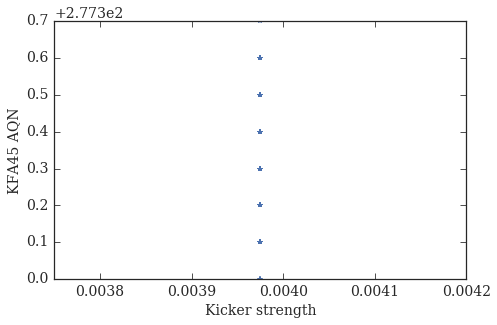

In [11]:
shiftVal=0
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['PI_KFA45.AQN1.value'],'*')
plt.xlabel('Kicker strength')
plt.ylabel('KFA45 AQN')

# Match the tomogram data

In [13]:
myDataFrame['deltaP_P_rms'] = 0.59e-3 
# no tomogram for these data

# Intensity

In [14]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][100]/np.max(x) )
myDataFrame['Intensity_max'] = myDataFrame['PR_BCT_ST.Samples.value.samples'].apply(lambda x: np.max(x))

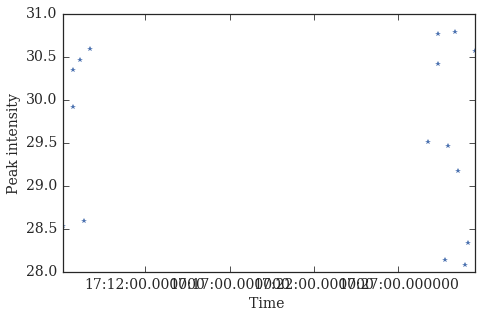

In [15]:
plt.plot(myDataFrame['Intensity_max'],'*')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,1))
plt.xlabel('Time ')
plt.ylabel('Peak intensity')

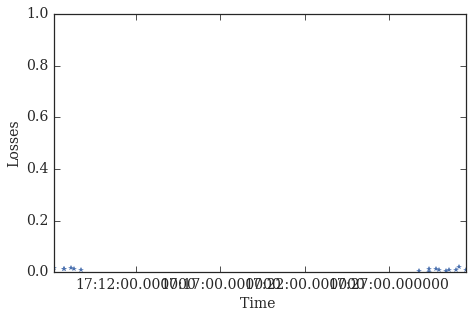

In [16]:
plt.plot(myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1))
plt.xlabel('Time ')
plt.ylabel('Losses')

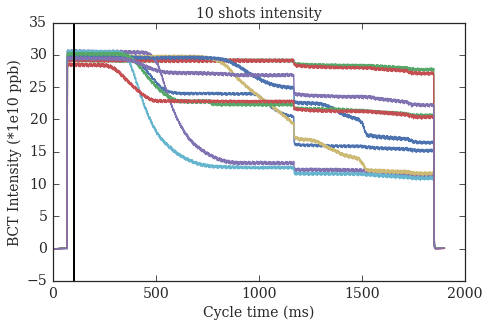

In [21]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=100, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

# Calculate wire scanner emittance
## X plane
### Traditional method

In [46]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
    
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])

In [47]:
myDataFrame['WS_sigma_x']

2017-12-05 17:41:57.100    4.722264
2017-12-05 17:42:40.300    4.805964
2017-12-05 17:42:40.300    4.805964
2017-12-05 17:43:04.300    4.836525
2017-12-05 17:43:23.500    4.859208
2017-12-05 17:43:47.500    4.723403
2017-12-05 17:44:06.700    4.772740
2017-12-05 17:44:30.700    4.798972
2017-12-05 17:44:49.900    4.866543
2017-12-05 17:45:13.900    4.795152
Name: WS_sigma_x, dtype: float64

In [41]:
# Emittance calculation
myDataFrame['WS_emittance_x'] = np.nan
myDataFrame['WS_geom_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    print n
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=myDataFrame['deltaP_P_rms'].values[n])
    myDataFrame['WS_geom_emittance_x'].iloc[n] = myDataFrame['WS_emittance_x'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

0


KeyError: 'deltaP_P_rms'

In [108]:
myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].iloc[0]

array([-51860, -51758, -51724, ...,  51836,  51855,  51873], dtype=int32)

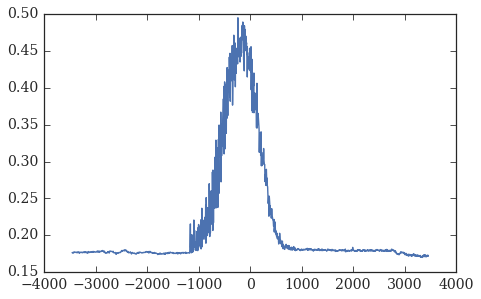

In [115]:
plt.plot((1./15)*myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].iloc[80],myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[80])

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))




## Y plane

In [27]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

In [28]:
# Emittance calculation
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance('85V',x))

myDataFrame['WS_geom_emittance_y'] = np.nan
for n in range(len(myDataFrame)):
    myDataFrame['WS_geom_emittance_y'].iloc[n] = myDataFrame['WS_emittance_y'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

## Emittance plot

In [88]:
myDataFrame['WS_emittance_x'].shape

(199,)

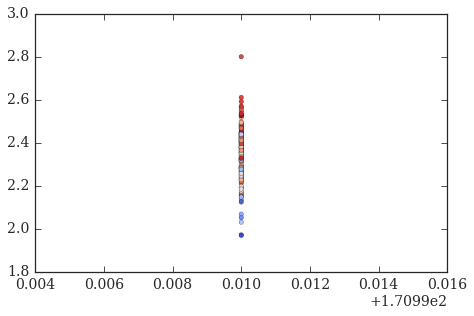

In [92]:
fig, ax = plt.subplots(1)

ax.scatter(myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1'], myDataFrame['WS_emittance_x'], c=myDataFrame['Intensity_max'], cmap=plt.cm.coolwarm)


# plt.plot(myDataFrame['WS_emittance_x'].values,'.')
# plt.ylabel('Normalised emittance (mm.mrad)')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1.5,4.2))


# ax.plot(myDataFrame['WS_emittance_y'],'.',label='$\epsilon_{y, norm}$')

# plt.legend(frameon=True)

# fig.savefig('BCMS_under_coupling_emi_xy.eps', format='eps')

In [93]:
myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1']

2017-12-05 18:08:16.300    171
2017-12-05 18:08:59.500    171
2017-12-05 18:09:18.700    171
2017-12-05 18:09:42.700    171
2017-12-05 18:10:01.900    171
2017-12-05 18:10:25.900    171
2017-12-05 18:10:45.100    171
2017-12-05 18:11:09.100    171
2017-12-05 18:11:28.300    171
2017-12-05 18:11:52.300    171
2017-12-05 18:12:11.500    171
2017-12-05 18:12:35.500    171
2017-12-05 18:12:54.700    171
2017-12-05 18:13:18.700    171
2017-12-05 18:13:37.900    171
2017-12-05 18:14:01.900    171
2017-12-05 18:14:21.100    171
2017-12-05 18:14:45.100    171
2017-12-05 18:15:04.300    171
2017-12-05 18:15:28.300    171
2017-12-05 18:15:47.500    171
2017-12-05 18:16:11.500    171
2017-12-05 18:16:30.700    171
2017-12-05 18:17:06.700    171
2017-12-05 18:17:42.700    171
2017-12-05 18:18:18.700    171
2017-12-05 18:18:54.700    171
2017-12-05 18:19:30.700    171
2017-12-05 18:20:06.700    171
2017-12-05 18:20:42.700    171
                          ... 
2017-12-05 19:45:41.500    171
2017-12-

In [ ]:
fig, ax = plt.subplots(1)
ax.scatter(np.linspace(172,175,199), myDataFrame['WS_emittance_x'], c=myDataFrame['Intensity_max'], cmap=plt.cm.coolwarm)


# BPMs

In [ ]:
# BPMs
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,1])
# #turn to millimiters and cast in float
myDataFrame['BPMx_turn1'] = myDataFrame['BPMx_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn1'] = myDataFrame['BPMy_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMx_turn2'] = myDataFrame['BPMx_turn2'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn2'] = myDataFrame['BPMy_turn2'].apply(lambda x: x/10.)
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[-43:,1])
myDataFrame['Orbit_x'] = myDataFrame['Orbit_x'].apply(lambda x: x/10.)
myDataFrame['Orbit_y'] = myDataFrame['Orbit_y'].apply(lambda x: x/10.)

In [ ]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23.outx')

# Calculate injection oscillation from the BPM

## 1. Look at one BPM and calculate the oscillation over the first 50 turns

In [ ]:
# get the beta at the BPMs position
optics_names = optics.NAME
BPM_name = []
BPM_idx = []
BPM_betax = []
BPM_alphax = []

for k in range(len(optics_names)):
    if optics_names[k].find('PR.BPM') != -1:
#        print optics_names[k]
        BPM_name.append(optics_names[k])
        BPM_idx.append(k)
        BPM_betax.append(optics.BETA11[k])   
        BPM_alphax.append(optics.ALFA11[k])

# for some reason the last bpm is the 00, place it back at the beginning
BPM_name = [BPM_name[-1]] + BPM_name[:-1]
BPM_idx = [BPM_idx[-1]] + BPM_idx[:-1]
BPM_betax = [BPM_betax[-1]] + BPM_betax[:-1]
BPM_alphax = [BPM_alphax[-1]] + BPM_alphax[:-1]

In [ ]:
# loop over all the BPM

# fit an harmonic function through the oscillations and extrapolate the amplitude. 
# possible tunes (non integer part) have been restricted to be between .20 and .25 --> 2pi/5 and pi/2

from scipy.optimize import curve_fit
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,30,30)
osc_amplitude = np.empty([len(myDataFrame),len(BPM_name)],dtype=float); osc_amplitude[:]=np.nan

# fit boundaries 
bounds=([-np.inf, 1.*pi/5, -pi, -np.inf],[np.inf,pi/2.,pi,np.inf])
# statistical check
chi2 = np.empty([len(myDataFrame),len(BPM_name)],dtype=float)

for m in range(len(BPM_name)):

    for k in range(len(myDataFrame)):
        ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[m,0:30]).values[k]
        # starting values
        p0 = ([2*signalRMS(ydata), 0.45*pi, pi/2, np.mean(ydata)])

        try:
            p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)
            osc_amplitude[k,m] = np.abs(p[0])

            yfit = f_to_fit(xdata, *p)
            chi2[k,m] = np.sum((yfit - ydata)**2)/len(yfit)

        except RuntimeError:
            print 'fit do not converge on shot '+str(k)
            osc_amplitude[k,m] = np.nan
            chi2[k,m] = np.nan
        
    print BPM_name[m] + ' processed with success '+ str(np.count_nonzero(~np.isnan(osc_amplitude[:,m]))) +'/'+str(len(myDataFrame))+' shots'
            
print 'Done.'

In [ ]:
# sanity check 
for k in range(34):
    plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),osc_amplitude[:,k],'.')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0,10))

In [ ]:
# manual inspection
bpm_n = 21
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),osc_amplitude[:,bpm_n],'.')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,10))
print 'Beta_x at '+BPM_name[bpm_n]+': '+str(BPM_betax[bpm_n])

In [ ]:
plt.plot(chi2[:,bpm_n],'.')

In [ ]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(osc_amplitude[:139,:],
           cmap='hot',
           aspect='auto'
          )
plt.colorbar()
plt.xlabel('BPM number')
plt.ylabel('Shot number')

## 2. RMS orbit deviation 1st-2nd turn and 1st turn-1ms orbit

### calculate the RMS orbit deviation
Use difference between the first and second turn to evaluate the orbit deviation from the reference orbit, where


$$\Delta x_\text{rms} =  \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn2} - x_\text{turn1})^2 }$$


excluding the BPM in the bump, that would dominate the estimator.

Same for the deviation from the orbit 

$$\Delta x_\text{rms, orbit} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn1} - x_\text{average_orbit_1ms})^2 }$$

In [ ]:
# X plane
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMx_turn2'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

myDataFrame['deltaX_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
myDataFrame['OrbitX_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

# Y plane
mySeries1 = myDataFrame['BPMy_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMy_turn2'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_y'].apply(lambda x: np.delete(x,17))

myDataFrame['deltaY_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
myDataFrame['OrbitY_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

In [ ]:
plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaX_2turns'].values,'*',label='X plane')

plt.xlabel('Kick (mrad)')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference')

plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaY_2turns'].values,'*',label='Y plane')



plt.legend(frameon=True)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,8))
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

In [ ]:
plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['OrbitX_dev_RMS'].values,'*',label='X plane')

plt.xlabel('Kick (mrad)')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')
plt.title('First turn RMS orbit difference from closed orbit')

plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['OrbitY_dev_RMS'].values,'*',label='Y plane')


plt.legend(frameon=True)
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,8))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

# Methods comparison

## 1) Single BPM method

In [ ]:
bpm_n1 = 25
osc1 = osc_amplitude[:,bpm_n1]
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))
bpm_n2 = 21
osc2 = osc_amplitude[:,bpm_n2]
print 'At '+BPM_name[bpm_n2]+' betax='+str(BPM_betax[bpm_n2])+' alphax='+str(BPM_alphax[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n2]**2)/(2*BPM_betax[bpm_n2]))

In [ ]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = 1e-3*osc1
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('$\Delta_x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n1])

ax.text(0.35, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.3f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))

In [ ]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = 1e-3*osc2
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('$\Delta_x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n2])

ax.text(0.35, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.3f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n2]+' betax='+str(BPM_betax[bpm_n2])+' alphax='+str(BPM_alphax[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n2]**2)/(2*BPM_betax[bpm_n2]))
print 'Theoretically a=(1+alpha^2)/2beta'

## 2) All BPM - single turn method

In [ ]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = 1e-3*myDataFrame['deltaX_2turns']
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('$\Delta_{x,RMS}$ (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title('First/second turn RMS difference')

ax.text(0.35, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.3f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'Expected value for the fit a='+str(1./(2.*16.))

In [ ]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = 1e-3*myDataFrame['OrbitX_dev_RMS']
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('$\Delta_{x,RMS}$ (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title('First turn/orbit difference')

ax.text(0.35, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.3f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'Expected value for the fit a='+str(1./(2.*16.))

# Laslett tune shift calculation

In [ ]:
myDataFrame['peakLineDensity'] = 0.39

In [ ]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [ ]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

In [ ]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.207
Qy = 6.155
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([6.1, 6.26])
plt.ylim([6.05, 6.26])
# tune shifts


p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

# PSB point
[deltaQxPSB, deltaQyPSB] = laslett_sc_PS(0.39, 0.5e-3,
              1e-6*2.312, 1e-6*2.143,
              1400, twiss_file_name)
plt.plot(Qx+deltaQxPSB,Qy+deltaQyPSB,'*',markersize=15)


plt.show()

fig.savefig('BCMS_under_coupling_footprint.eps', format='eps')

In [ ]:
--> fix the peak line density in the tomogram function
--> Turn your library into a class, define the methods as static methods and change all the callers as eTools.functionNaME()
--> implementa il local indexing instaed of the iloc in the dataframe